In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]


In [3]:
import math
import os
import pickle
import random
from datetime import datetime

import numpy as np
import torch
from matplotlib import pyplot as plt
from music21 import converter
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from IPython.display import display, Audio

from utils import decode_midi

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


In [5]:
torch.manual_seed(0);

## Data processing

In [6]:
DATA_ROOT = "data/pop_pickle"
N_SAMPLES = 909
VOCAB_SIZE = 390
BOS_TOKEN = VOCAB_SIZE - 2
PAD_TOKEN = VOCAB_SIZE - 1

In [7]:
dataset = []
for i in range(N_SAMPLES):
    file_name = str(i + 1).zfill(3) + ".pickle"
    path = os.path.join(DATA_ROOT, file_name)
    with open(path, "rb") as f:
        seq = pickle.load(f)
        seq_tensor = torch.LongTensor(seq)
    dataset.append(seq_tensor)

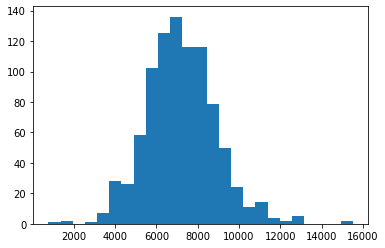

In [8]:
seq_lens = [len(seq) for seq in dataset]

plt.figure()
plt.hist(seq_lens, bins=25)
plt.show()

In [9]:
N_VAL = N_TEST = int(0.05 * 909)
N_TRAIN = 909 - (N_VAL + N_TEST)

train_songs = dataset[:N_TRAIN]
val_songs = dataset[N_TRAIN:N_TRAIN+N_VAL]
test_songs = dataset[N_TRAIN+N_VAL:]

print(f"Train: {len(train_songs)} \t Val: {len(val_songs)} \t Test: {len(test_songs)}")

Train: 819 	 Val: 45 	 Test: 45


In [10]:
def batchify(seq, new_seq_len):
    """
    Convert a sequence into a batch of equal-length sequences,
    and prepend a BOS token at the start of every sequence.
    
    Unless new_seq_len perfectly divides the number of tokens
    in seq, the last sequence will be padded with PAD_TOKENs.
    """
    n = seq.numel() % new_seq_len
    pad_size = 0 if n == 0 else new_seq_len - n
    pad = torch.full(size=(pad_size,), fill_value=PAD_TOKEN)
    seq = torch.cat([seq, pad])
    assert seq.numel() % new_seq_len == 0
    num_batches = int(seq.numel() / new_seq_len)
    batch = seq.view(num_batches, -1)
    bos = torch.full(size=(num_batches, 1), fill_value=BOS_TOKEN)
    batch = torch.cat([bos, batch], dim=1)    
    return batch

In [11]:
SEQ_LEN = 1024

train_data = torch.cat([batchify(seq, SEQ_LEN) for seq in train_songs])
val_data = torch.cat([batchify(seq, SEQ_LEN) for seq in val_songs])
test_data = torch.cat([batchify(seq, SEQ_LEN) for seq in test_songs])

print(f"Train: {len(train_data)} \t Val: {len(val_data)} \t Test: {len(test_data)}")

Train: 6166 	 Val: 355 	 Test: 336


## Training an LSTM model

In [12]:
class MusicRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, rnn_type="lstm", num_layers=1, dropout=0.0):
        assert rnn_type in ["lstm", "gru"]

        super().__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.dropout = dropout

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        if rnn_type == "lstm":
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True) 
        else:
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
        self.hidden_state = None

    def forward(self, x, reset_hidden_state=True):
        x = self.embeddings(x)
        if reset_hidden_state:
            x, _ = self.rnn(x)
        else:
            x, self.hidden_state = self.rnn(x, self.hidden_state)
        x = self.fc(x)
        return x

    def generate_sequence(self, seq_start=None, max_length=1024, **kwargs):
        if not seq_start:
            seq_start = [BOS_TOKEN]
        seq = seq_start.copy()
        with torch.no_grad():
            next_token = self._generate_next_token(
                next_input=torch.LongTensor(seq).to(device),
                reset_hidden=True,
                **kwargs
            )
            while len(seq) <= max_length:
                next_token = self._generate_next_token(
                    next_input=torch.LongTensor([next_token]).to(device),
                    reset_hidden=False,
                    **kwargs
                )
                seq.append(next_token)
        return seq
    
    def _generate_next_token(self, next_input, reset_hidden=False, temp=1.0, topk=5, argmax=False):
        # The model expects a batch input, so we add a fake batch dimension.
        model_input = next_input.unsqueeze(0)
        # Then, we need to remove the fake batch dimension from the output.
        model_output = self(model_input, reset_hidden).squeeze(0)
        next_token_probs = F.softmax(model_output[-1] / temp, dim=0)
        if argmax:
            next_token = torch.argmax(next_token_probs)
        else:
            top_tokens = torch.topk(next_token_probs, topk)
            top_indices = top_tokens.indices
            top_probs = top_tokens.values
            top_probs /= torch.sum(top_probs)
            next_token = np.random.choice(top_indices.cpu().numpy(), p=top_probs.cpu().numpy())
        return next_token.item()

In [13]:
def validate(model, data_loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for batch in data_loader:
            batch = batch.to(device)
            x = batch[:, :-1]
            y = batch[:, 1:]
            y_hat = model(x)
            y_hat = y_hat.transpose(1, 2)
            loss = loss_function(y_hat, y)
            total_loss += loss.item()
        ppl = math.exp(total_loss / len(data_loader))
        return ppl

def remove_special_tokens(seq):
    return [token for token in seq if token not in [BOS_TOKEN, PAD_TOKEN]]

def display_audio(seq, outfile):
    seq = remove_special_tokens(seq)
    decode_midi(seq, outfile)
    stream = converter.parse(outfile)
    stream.show("midi")

In [14]:
NUM_LAYERS = 1
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
NUM_EPOCHS = 250
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
CLIPPING_THRESHOLD = 1.0
DROPOUT = 0.0

LOG_EVERY_N = 1
VAL_EVERY_N = 10
SAVE_EVERY_N = 10

In [15]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=torch.stack,
)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=torch.stack,
)

In [ ]:
model = MusicRNN(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    vocab_size=VOCAB_SIZE,
    rnn_type="lstm",
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
print(model)

In [ ]:
now = datetime.now().strftime("%Y-%m-%d_%H:%M")
exp_name = (
    f"{model.rnn_type}({EMBEDDING_DIM},{HIDDEN_DIM}),"
    f"lr={LEARNING_RATE},bsz={BATCH_SIZE},nepochs={NUM_EPOCHS},"
    f"sl={SEQ_LEN},dropout={DROPOUT},t={now}"
)
writer = SummaryWriter(f"runs/{exp_name}")

In [ ]:
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader):
        # Move to GPU if available.
        batch = batch.to(device)

        # Reset gradients.
        model.zero_grad()

        # Prepare inputs and targets.
        x = batch[:, :-1]
        y = batch[:, 1:]
                
        # Forward prop.
        y_hat = model(x)
        
        # Swap token dim and output dim.
        y_hat = y_hat.transpose(1, 2)
        
        # Compute loss.
        loss = loss_function(y_hat, y)
        total_loss += loss.item()

        # Back prop.
        loss.backward()
        
        # Clip gradients.
        clip_grad_norm_(model.parameters(), CLIPPING_THRESHOLD)
        
        # Update parameters.
        optimizer.step()
        
    if epoch % LOG_EVERY_N == 0:
        avg_loss = total_loss / len(train_loader)  # per token loss
        writer.add_scalar("train_loss", avg_loss, global_step=epoch)
        
        train_ppl = math.exp(avg_loss)
        writer.add_scalar("train_ppl", train_ppl, global_step=epoch)

    if epoch % VAL_EVERY_N == 0:
        val_ppl = validate(model, val_loader)
        writer.add_scalar("val_ppl", val_ppl, global_step=epoch)
        seq = model.generate_sequence(temp=1.0, topk=32)
        display_audio(seq)

    if epoch % SAVE_EVERY_N == 0:
        state_checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(state_checkpoint, f"models/lstm_checkpoints/ckpt_{epoch}.pt")

## Training a transformer model

In [ ]:
import time

from music_transformer import custom
from music_transformer import utils
from music_transformer.custom.metrics import *
from music_transformer.custom.criterion import SmoothCrossEntropyLoss, CustomSchedule
from music_transformer.custom.config import config
from music_transformer.data import Data
from music_transformer.model import MusicTransformer

In [ ]:
def validate_transformer(transformer, data_loader):
    transformer.eval()
    val_loss = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    with torch.no_grad():
        total_loss = 0.0
        for batch in data_loader:
            batch = batch.to(device)
            x = batch[:, :-1]
            y = batch[:, 1:]
            y_hat = transformer(x).transpose(1, 2)
            loss = val_loss(y_hat, y)
            total_loss += loss.item()
        ppl = math.exp(total_loss / len(data_loader))
        return ppl

In [ ]:
NUM_LAYERS = 4
EMBEDDING_DIM = 256
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
BATCH_SIZE = 8
DROPOUT = 0.1
LABEL_SMOOTHING = 0.1

LOG_EVERY_N = 1
VAL_EVERY_N = 2
SAVE_EVERY_N = 10

In [ ]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=torch.stack,
)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=torch.stack,
)

In [ ]:
transformer = MusicTransformer(
    embedding_dim=EMBEDDING_DIM,
    vocab_size=VOCAB_SIZE,
    num_layer=NUM_LAYERS,
    max_seq=SEQ_LEN,
    dropout=DROPOUT,
).to(device)

print(transformer)

In [ ]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
scheduler = CustomSchedule(EMBEDDING_DIM, optimizer=optimizer)
loss_function = SmoothCrossEntropyLoss(LABEL_SMOOTHING, VOCAB_SIZE, PAD_TOKEN)
val_loss = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

In [ ]:
now = datetime.now().strftime("%Y-%m-%d_%H:%M")
exp_name = (
    f"Transformer({EMBEDDING_DIM},{VOCAB_SIZE},{NUM_LAYERS}),"
    f"lr={LEARNING_RATE},bsz={BATCH_SIZE},nepochs={NUM_EPOCHS},"
    f"sl={SEQ_LEN},dropout={DROPOUT},t={now}"
)
writer = SummaryWriter(f"runs/{exp_name}")

In [ ]:
for epoch in range(NUM_EPOCHS):
    transformer.train()
    total_loss = 0.0
    for batch in tqdm(train_loader):
        # Move to GPU if available.
        batch = batch.to(device)

        # Reset gradients.
        transformer.zero_grad()
        
        # Prepare inputs and targets.
        x = batch[:, :-1]
        y = batch[:, 1:]

        # Forward prop.
        y_hat = transformer(x)

        loss = loss_function(y_hat, y)
        total_loss += loss.item()
        
        # Back prop.
        loss.backward()

        # Step scheduler (and optimizer).
        scheduler.step()
        
    if epoch % LOG_EVERY_N == 0:
        avg_loss = total_loss / len(train_loader)  # per token loss
        writer.add_scalar("train_loss", avg_loss, global_step=epoch)
    
    if epoch % VAL_EVERY_N == 0:
        ppl = validate_transformer(transformer, val_loader)
        writer.add_scalar("val_ppl", ppl, global_step=epoch)
        
        primer = torch.LongTensor([[BOS_TOKEN]]).to(device)
        seq = transformer.generate(primer, length=1024)
        display_audio(seq.tolist())

    if epoch % SAVE_EVERY_N == 0:
        state_checkpoint = {
            "epoch": epoch,
            "model_state_dict": transformer.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(state_checkpoint, f"models/checkpoints/ckpt_{epoch}.pt")

In [ ]:
state_checkpoint = {
    "epoch": epoch,
    "model_state_dict": transformer.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}
torch.save(state_checkpoint, f"models/Transformer(256,390,4),lr=0.001,bsz=8,nepochs=1000,sl=1024,dropout=0.1,t=2020-11-14_12:52.pt")

## Model evaluation

In [158]:
model_old = MusicRNN(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    vocab_size=VOCAB_SIZE,
    rnn_type="lstm",
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(device)
state_dict = torch.load("models/ckpt_200.pt")["model_state_dict"]
model_old.load_state_dict(state_dict)

<All keys matched successfully>

In [168]:
keys
len(keys)

25

In [167]:
winners = [2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2]
len(winners)

25

In [169]:
p1_wins = p2_wins = 0
for p1, w in zip(keys, winners):
    if p1 == w:
        p1_wins += 1
    else:
        p2_wins += 1

print(p1_wins, p2_wins)

9 16


In [164]:
FIRST_N = 128
LENGTH = 1024

keys = []
for i in range(20, 45):
    print(f"Test song {i}")
    
    random_key = random.choice([1, 2])
    keys.append(random_key)

    primer = test_songs[-i][:FIRST_N]
    display_audio(primer.tolist(), f"data/music_out/fb_comp/{str(i).zfill(2)}_primer.mid")

    lstm_input = primer.tolist()

    old_continuation = model.generate_sequence(lstm_input, temp=1.0, topk=128, max_length=LENGTH)
    display_audio(old_continuation, f"data/music_out/fb_comp/{str(i).zfill(2)}_{random_key}.mid")
    
    lstm_continuation = model.generate_sequence(lstm_input, temp=1.0, topk=128, max_length=LENGTH)
    display_audio(lstm_continuation, f"data/music_out/fb_comp/{str(i).zfill(2)}_{3-random_key}.mid")

    # transformer_input = primer.unsqueeze(0).to(device)
    # transformer_continuation = transformer.generate(transformer_input, length=LENGTH).tolist()
    # display_audio(transformer_continuation, f"data/music_out/{str(i).zfill(2)}_transformer.mid")

    # real_continuation = test_songs[i][:LENGTH].tolist()
    # display_audio(real_continuation, f"data/music_out/tmp/{str(i).zfill(2)}_real.mid")

Test song 20


Test song 21


Test song 22


Test song 23


Test song 24


Test song 25


Test song 26


Test song 27


Test song 28


Test song 29


Test song 30


Test song 31


Test song 32


Test song 33


Test song 34


Test song 35


Test song 36


Test song 37


Test song 38


Test song 39


Test song 40


Test song 41


Test song 42


Test song 43


Test song 44


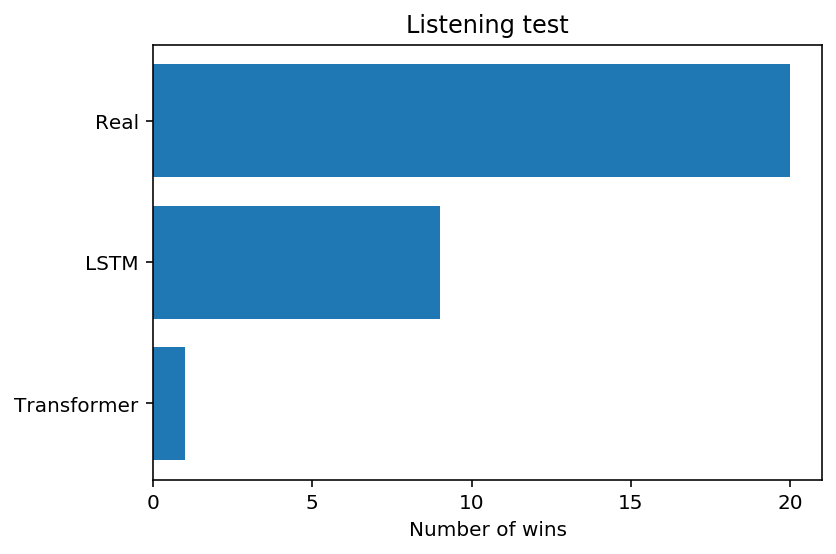

In [113]:
plt.figure()
labels = ["Transformer", "LSTM", "Real"]
num_wins = [1, 9, 20]
plt.title("Listening test")
plt.barh(labels, num_wins)
plt.xlabel("Number of wins")
plt.xticks([0, 5, 10, 15, 20])
plt.show()

## Getting Listener Feedback

In [114]:
feedback_data = []
feedback_data = torch.load("data/feedback/feedback_2.pt")

In [49]:
FIRST_N = 128
LENGTH = 1024
NUM_CROPS = 5
CROP_LENGTH = 128

In [136]:
display_audio(primer.tolist() + lstm_continuation, f"data/music_out/tmp/crop_tmp.mid")

In [147]:
test_song = random.choice(test_songs)
primer = test_song[:FIRST_N]
lstm_input = primer.tolist()
lstm_continuation = model.generate_sequence(lstm_input, temp=1.0, topk=128, max_length=LENGTH)[FIRST_N:]
crops = []
for _ in range(NUM_CROPS):
    start_index = np.random.randint(0, len(lstm_continuation) - CROP_LENGTH)
    end_index = start_index + CROP_LENGTH
    random_crop = lstm_continuation[start_index:end_index]
    crops.append(random_crop)
    display_audio(random_crop, f"data/music_out/tmp/crop_tmp.mid")

In [148]:
rewards = [1, 3, 1, 0, 0]
feedback = list(zip(crops, rewards))
feedback_data = feedback_data + feedback
feedback_data = [d for d in feedback_data if d[1] > 0]
print(f"Num samples: {len(feedback_data)}")

Num samples: 96


In [149]:
torch.save(feedback_data, "data/feedback/feedback_3.pt")

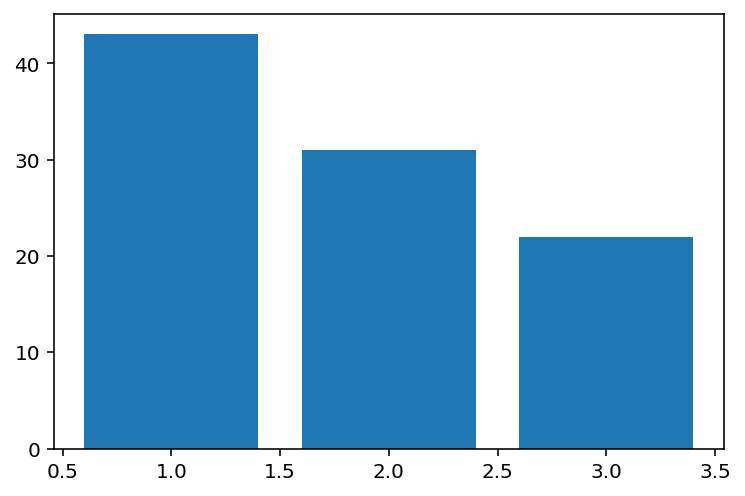

In [150]:
from collections import Counter

reward_counter = Counter([f[1] for f in feedback_data])
reward_counts = reward_counter.values()
reward_labels = reward_counter.keys()

plt.figure()
plt.bar(reward_labels, reward_counts)
plt.show()

## Feedback training

In [66]:
BATCH_SIZE = 128
FB_BATCH_SIZE = 8
ALPHA = 0.99
LAMBDA = 0.5
NUM_EPOCHS = 16

LOG_EVERY_N = 1
VAL_EVERY_N = 5
SAVE_EVERY_N = 1

In [67]:
print(len(train_data) / BATCH_SIZE)
print(len(feedback_data) / FB_BATCH_SIZE)

48.171875
4.375


In [73]:
model = MusicRNN(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    vocab_size=VOCAB_SIZE,
    rnn_type="lstm",
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(device)
state_dict = torch.load("models/ckpt_200.pt")["model_state_dict"]
model.load_state_dict(state_dict)

<All keys matched successfully>

In [151]:
xe_loss = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN, reduction="none")
def fb_loss_function(y_hat, y, rewards, alpha):
    xe = xe_loss(y_hat, y)
    K = xe.shape[1]
    coef = (alpha - 1) / (alpha ** K - 1)
    weights = coef * np.power(alpha, (K - np.arange(K) - 1))
    weights_tensor = torch.tensor(weights, device=device)
    weighted_xe = weights_tensor * xe
    loss_per_seq = rewards * torch.sum(weighted_xe, axis=1)
    return torch.mean(loss_per_seq)

loss_function = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [152]:
def collate_fn(samples):
    x = torch.LongTensor([sample[0] for sample in samples])
    y = torch.LongTensor([sample[1] for sample in samples])
    return x, y

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=torch.stack,
)
feedback_loader = DataLoader(
    feedback_data,
    batch_size=FB_BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
)

In [153]:
now = datetime.now().strftime("%Y-%m-%d_%H:%M")
exp_name = (
    f"Feedback,bs={BATCH_SIZE},fbs={FB_BATCH_SIZE},alpha={ALPHA},"
    f"lambda={LAMBDA},nepochs={NUM_EPOCHS},t={now}"
)
writer = SummaryWriter(f"runs/{exp_name}")

In [154]:
for epoch in trange(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        fb_batch, fb_rewards = next(iter(feedback_loader))

        # Move to GPU if available.
        batch = batch.to(device)
        fb_batch = fb_batch.to(device)
        fb_rewards = fb_rewards.to(device)

        # Reset gradients.
        model.zero_grad()

        # Prepare inputs and targets.
        x = batch[:, :-1]
        y = batch[:, 1:]
        fb_x = fb_batch[:, :-1]
        fb_y = fb_batch[:, 1:]
                
        # Forward prop.
        y_hat = model(x)
        fb_y_hat = model(fb_x)
        
        # Swap token dim and output dim.
        y_hat = y_hat.transpose(1, 2)
        fb_y_hat = fb_y_hat.transpose(1, 2)
        
        # Compute loss.
        orig_loss = loss_function(y_hat, y)
        fb_loss = fb_loss_function(fb_y_hat, fb_y, fb_rewards, alpha=ALPHA)
        loss = orig_loss + LAMBDA * fb_loss
        total_loss += loss.item()

        # Back prop.
        loss.backward()
        
        # Clip gradients.
        clip_grad_norm_(model.parameters(), CLIPPING_THRESHOLD)
        
        # Update parameters.
        optimizer.step()
        
    if epoch % LOG_EVERY_N == 0:
        avg_loss = total_loss / len(train_loader)  # per token loss
        writer.add_scalar("train_loss", avg_loss, global_step=epoch)
        
        train_ppl = math.exp(avg_loss)
        writer.add_scalar("train_ppl", train_ppl, global_step=epoch)

    if epoch % VAL_EVERY_N == 0:
        val_ppl = validate(model, val_loader)
        writer.add_scalar("val_ppl", val_ppl, global_step=epoch)
        seq = model.generate_sequence(temp=1.0, topk=32)
        display_audio(seq, "data/music_out/tmp/tmp.mid")

    if epoch % SAVE_EVERY_N == 0:
        state_checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(state_checkpoint, f"models/fb_checkpoints/ckpt_{epoch}.pt")

In [157]:
torch.save(model.state_dict(), "models/fb_lstm_3.pt")

## Generating music

In [ ]:
lstm = MusicRNN(
    embedding_dim=64,
    hidden_dim=256,
    vocab_size=VOCAB_SIZE,
    rnn_type="lstm",
    num_layers=2,
    dropout=0.5,
).to(device)

sd = torch.load("models/lstm(64,256),lr=0.001,bsz=256,nepochs=250,sl=1024,dropout=0.5,t=2020-11-13_14:30.pt")["model_state_dict"]
lstm.load_state_dict(sd)

In [ ]:
FIRST_N = 125
IDX = 10

primer = test_songs[IDX][:FIRST_N].tolist()
display_audio(primer)

In [ ]:
# primer = torch.LongTensor([[BOS_TOKEN]]).to(device)
primer = test_songs[IDX][:FIRST_N].unsqueeze(0).to(device)
seq = transformer.generate(primer, length=1024)
display_audio(seq.tolist())

In [ ]:
primer = test_songs[IDX][:FIRST_N].tolist()
continuation = lstm.generate_sequence(primer, temp=1.0, topk=128)
display_audio(continuation)